# 신경망의 학습

- 학습이란 간단히 말하면 각 가중치들을 최적이 될수 있도록 estimation하고 수정하는 과정을 말함.
- 이때 학습이 잘 진행되고 있는지를 판단하기 위해 loss와 cost를 정의함. loss가 어떻게 정의 되는지에 따라 신경망이 잘 작동하는지를 판단하는 근거가 되고 학습이 잘 진행됨.
- 전통적인 기계학습 방법과의 차이점은 딥러닝은 end-to-end 방식이지만, 전통적인 방법들은 일반적으로 특징 추출과 classification의 과정을 별도로 진행했음.

## loss function

- 손실함수는 다양한것들이 존재하지만 여기서는 가장 유명한 mean square와 cross entropy를 구현해본다.

In [10]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
def mean_squared_error(t, y):
    return 0.5 * np.sum((y-t)**2)

In [3]:
def cross_entropy(t, y):
    return -np.sum(t*np.log(y))

- cross entropy의 경우 log함수를 사용하는데 아주 작은 값이 될경우 지수함수는 음의 무한대 값을 가지고 있기 때문에 아주 작은 값을 보정값으로 더해주는 것을 보통 사용한다.

In [4]:
def cross_entropy(t, y):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

- 왜 손실함수를 사용해야 하는가?  
간단한게 설명하면 신경망의 학습에 사용되는 역전파의 계산에 미분이 사용됨. 이때의 미분값은 가중치들을 아주 조금 변화 시키면 손실함수가 어떻게 변하냐를 의미함. 이 값들을 사용해서 각 매개변수들을 변화하는 과정이 신경망의 학습임. 하지만 손실함수 말고 정확도와 같은 값을 지표로 삼을 경우에는 미분값들이 대부분 0으로 나오기 때문에 제대로된 학습이 될수 없음.

## 미분의 구현

In [5]:
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h)-f(x))/h

- 단순한 미분의 구현은 위와 같이 할수 있음. 하지만 위와 같은 구현은 좋은 구현은 아님. 왜냐하면 "반올림 오차"라고 하는 문제를 발생함.
- 반올림 오차는 파이썬이 아주 작은 값에서 반올림을 하기 때문에 발생하는 오차를 말함. 아래 예시

In [7]:
np.float32(1e-50)

0.0

- 따라서 h로 너무 작은 값을 사용하지 말고 적정한 값을 사용하는 것도 중요. 1e-40이 좋다고 알려져 있음. 추가적인 문제로는 실질적인 미분의 정의는 해당 점에서의 접선의 기울기이지만 해당 구현은 두점 사이의 기울기임. 따라서 엄밀히 말해서는 같은 값이 아님.

In [8]:
def numerical_diff(f,x):
    h = 1e-40
    return (f(x+h)-f(x-h)/2*h)

0.75


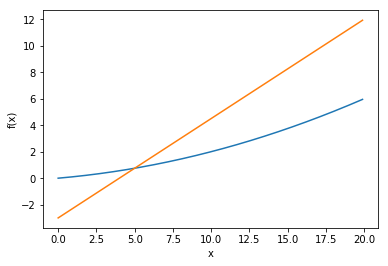

In [13]:
def function_1(x):
    return 0.01*x**2 + 0.1*x 


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

### 편미분과 기울기

- 위의 구현은 변수가 하나인 경우의 미분임. 하지만 실제로 우리가 계산해야하는 미분은 여러 변수로 구성된 함수의 미분인 편미분!
- 실제 구현에서는 단순하지만 각 매개변수마다 반복을 통해서 각각 기울기를 구해주는 방식으로 구현해봄.

In [25]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


In [32]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

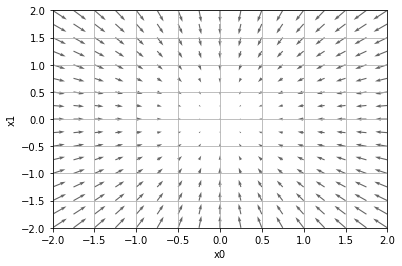

In [37]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]).T).T

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()


- 위 그림과 같이 기울기를 그리면 기울기들이 나오게 됨.
- 한가지 주의할점은 기울기들이 낮은 방향을 가르키는 것이 아니라. 각 점에서 함수의 출력값을 가장 줄이는 방향을 가르키고 있는 것임.

## 경사 하강법

- 편미분과 기울기를 통해서 구해진 값을 사용해서 손실함수를 최소화 하기 위해서 기울기가 가르키는 방향으로 움직여야함.
- 그 일정거리 만큼 움직이기 위해서 사용하는것이 학습률 learning rate임. 한번에 얼만큼 기울기를 반영할지로 생각.
- 이렇게 기울기를 최소화 하는 학습 방법이 경사 하강법(gradient descent)임.

In [42]:
def gradient_descent(f, init_x, lr = 0.01, step_num=100):
    x = init_x
    x_history = [] # 각 단계의 시각화를 위해 사용
    
    for i in range(step_num):
        x_history.append( x.copy() )
        grad = numerical_gradient(f, x)
        x -= lr*grad
    return x , np.array(x_history)

- 실제로 각 기울기 값을 업데이트 하면서 값의 변화를 시각화 해보자.

In [46]:
def function_2(x):
    return x[0]**2 + x[1]**2

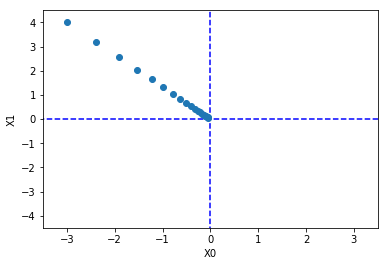

In [47]:
init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

- 실제 값이 점점 원점에 가까워지는 것을 확인할수 있다.

In [49]:
import sys, os
sys.path.append(os.pardir)


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [50]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet


(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    

    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

ModuleNotFoundError: No module named 'dataset'